# Policy Gradient Methods

In [1]:
import gymnasium as gym
import numpy as np
import time, matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [2]:
SEED = 327
rng = np.random.default_rng(SEED)

## REINFORCE

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

### Póliza Softmax

El entorno de CartPole-v1 tiene un espacio de acciones discreto:

| Acción | Descripción                       |
|--------|-----------------------------------|
| 0      | Mover el carro a la izquierda     |
| 1      | Mover el carro a la derecha       |

Por lo tanto, se usará `softmax` como **póliza parametrizable**

La función `softmax` parametrizable es:

$$
\pi(a|s, \theta) = \frac{e^{h(s, a, \theta)}}{\sum_{b} e^{h(s, b, \theta)}}
$$

donde:
$$
h(s, a, \theta)
$$ 

es una **preferencia parametrizable** que puede ser lineal:

$$
h(s, a, \theta) = \theta_a^T s
$$

Además, el espacio de estados es continuo, con los siguientes valores:

| Estado        | Descripción                       | Mínimo | Máximo |
|---------------|-----------------------------------|--------|--------|
| Cart Position | Posición del carro                | -4.8   | 4.8    |
| Cart Velocity | Velocidad del carro               | -Inf   | Inf    |
| Pole Angle    | Ángulo del poste                 | -24°   | 24°    |
| Pole Velocity | Velocidad angular del poste       | -Inf   | Inf    |

In [4]:
S = env.observation_space
A = env.action_space

In [5]:
class SoftmaxPolicy:
    def __init__(self):
        self.S_len = S.shape[0]
        self.A_len = A.n
        
        self.W = np.zeros((self.S_len, self.A_len))
        self.b = np.zeros(self.A_len)

    def logits(self, state):
        return state @ self.W + self.b

    def probs(self, state):
        logits = self.logits(state)
        exp_logits = np.exp(logits - np.max(logits))
        return exp_logits / np.sum(exp_logits)

    def sample(self, state):
        probs = self.probs(state)
        action = rng.choice(self.A_len, p=probs)
        return action, np.log(probs[action])


### Simulación

In [6]:
states = []
actions = []
rewards = []
log_probs = []

In [7]:
policy = SoftmaxPolicy()

In [8]:
done = False

In [9]:
state, info = env.reset(seed=SEED)
env.action_space.seed(SEED)

327

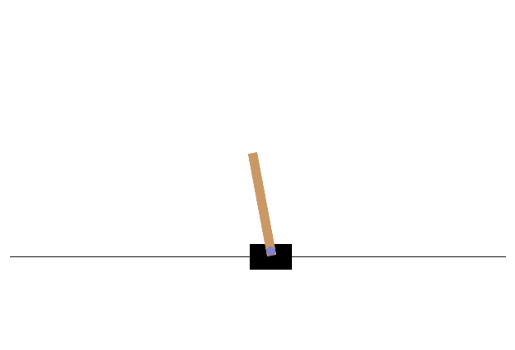

In [10]:
while not done:
    frame = env.render()
    plt.imshow(frame); plt.axis('off')
    display(plt.gcf()); clear_output(wait=True)
    
    action, log_prob = policy.sample(state)
    next_state, reward, done, truncated, info = env.step(action)
    
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    log_probs.append(log_prob)
    
    time.sleep(1/30)

    state = next_state
    done = done or truncated

In [11]:
episode_return = sum(rewards)

In [12]:
env.close()

### Rendimiento descontado para cada par de estado-acción

Dado que `REINFORCE` se basa en `Monte Carlo`, se usará el rendimiento descontado para cada par de estado-acción como $$G_t$$

$$
G_t = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}
$$

Además, como se ha visto, en estos casos al ser una estimación sin modelo del entorno, se usará la función valor estado-acción $$Q(s,a)$$ como una estimación del valor esperado del rendimiento descontado:

$$Q(s,a) \approx \mathbb{E}[G_t | S_t=s, A_t=a]$$

In [13]:
def compute_discounted_returns(rewards, gamma=0.99):
    n = len(rewards)
    discounted_returns = np.zeros(n)
    G = 0
    for t in reversed(range(n)):
        G = rewards[t] + gamma * G
        discounted_returns[t] = G
    return discounted_returns

In [14]:
discounted_return = compute_discounted_returns(rewards)

In [15]:
discounted_return

array([13.99416454, 13.12541872, 12.2478977 , 11.36151283, 10.46617457,
        9.5617925 ,  8.64827525,  7.72553056,  6.79346521,  5.85198506,
        4.90099501,  3.940399  ,  2.9701    ,  1.99      ,  1.        ])